# **extract from zip file**

In [ ]:
import zipfile
with zipfile.ZipFile('/content/resizedata.zip','r') as f:
  f.extractall('/content/resizedata')

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
import tensorflow as tf

# **Import the model to make segmentation**


In [22]:


smooth = 1e-15

def dice_coef(y_true, y_pred):
    # تحويل المدخلات إلى نوع float32 لتجنب مشاكل الحساب
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Flatten لتحويل المدخلات إلى شكل 1D
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)

    # حساب تقاطع Dice
    intersection = tf.reduce_sum(y_true * y_pred)

    # حساب Dice Coefficient
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
with CustomObjectScope({'dice_coef': dice_coef,'dice_loss': dice_loss}):
        model = tf.keras.models.load_model('/content/segmentmodelhhjj% (1).h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


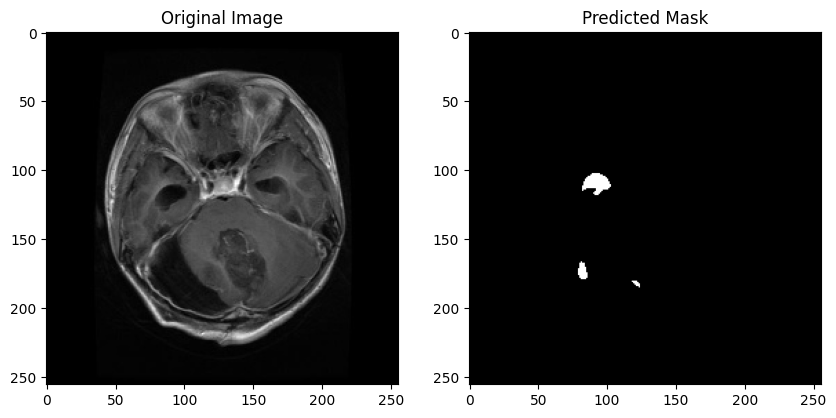

In [21]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import CustomObjectScope

# تعريف دالة Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1e-6):
    # حساب تقاطع Dice
    intersection = tf.reduce_sum(y_true * y_pred)
    # حساب Dice Coefficient
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# تعريف دالة Dice Loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# تحميل النموذج باستخدام CustomObjectScope
with CustomObjectScope({'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model('/content/segmentmodelhhjj% (1).h5')

# تحميل الصورة لاختبارها
def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # تحميل الصورة بالألوان الرمادية
    image_resized = cv2.resize(image, target_size)       # تغيير حجم الصورة
    image_normalized = image_resized / 255.0            # تطبيع الصورة إلى القيم بين 0 و 1
    image_normalized = np.expand_dims(image_normalized, axis=-1)  # إضافة بُعد القنوات
    image_normalized = np.expand_dims(image_normalized, axis=0)   # إضافة بُعد الدفعات
    return image_normalized

# مسار الصورة
image_path = '/content/resizedata/training_resized/glioma_tumor/gg (533).jpg'

# تجهيز الصورة
input_image = preprocess_image(image_path, target_size=(256, 256))  # غيّر الحجم حسب متطلبات النموذج

# التنبؤ باستخدام النموذج
predicted_mask = model.predict(input_image)

# إعادة تشكيل القناع الناتج إلى الأبعاد الأصلية للصورة
predicted_mask = (predicted_mask.squeeze() > 0.5).astype(np.uint8)  # تحويل القيم إلى 0 أو 1

# عرض الصورة الأصلية والقناع الناتج
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap='gray')

plt.show()


# **make segmentation to all types of four classses**

In [23]:
import os
import numpy as np
import cv2
import tensorflow as tf
from pathlib import Path

def predict_and_save(model, input_folder, output_folder, img_size=(256, 256)):
    # التأكد من وجود المجلد الناتج
    Path(output_folder).mkdir(parents=True, exist_ok=True)

    # التكرار على كل مجلد فرعي داخل مجلد الصور
    for subfolder in os.listdir(input_folder):
        input_subfolder_path = os.path.join(input_folder, subfolder)
        output_subfolder_path = os.path.join(output_folder, subfolder)

        # التأكد من وجود المجلد الناتج الفرعي
        Path(output_subfolder_path).mkdir(parents=True, exist_ok=True)

        # التكرار على كل صورة في المجلد الفرعي
        for image_name in os.listdir(input_subfolder_path):
            image_path = os.path.join(input_subfolder_path, image_name)
            output_image_path = os.path.join(output_subfolder_path, image_name)

            # قراءة الصورة بالأبيض والأسود وتحجيمها
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image_resized = cv2.resize(image, img_size)  # تغيير حجم الصورة إلى 256x256
            image_resized = image_resized / 255.0
            image_resized = np.expand_dims(image_resized, axis=-1)  # إضافة البعد للقناة
            image_resized = np.expand_dims(image_resized, axis=0)  # إضافة البعد للدفعة

            # التنبؤ بالقناع
            y_pred = model.predict(image_resized)
            y_pred = (y_pred > 0.5).astype(np.uint8)  # تحويل القيم إلى 0 و 1
            y_pred = np.squeeze(y_pred) * 255  # إزالة الأبعاد الإضافية وضبط القيم بين 0 و255

            # حفظ النتيجة
            cv2.imwrite(output_image_path, y_pred)


# تعيين مسارات المجلدات
input_folder = '/content/resizedata/training_resized'  # مسار المجلد الذي يحتوي على الصور الأصلية
output_folder = '/content/output'  # مسار المجلد لحفظ النتائج

# تشغيل الدالة لحفظ النتائج
predict_and_save(model, input_folder, output_folder)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

# **show  samples of photo and masks**

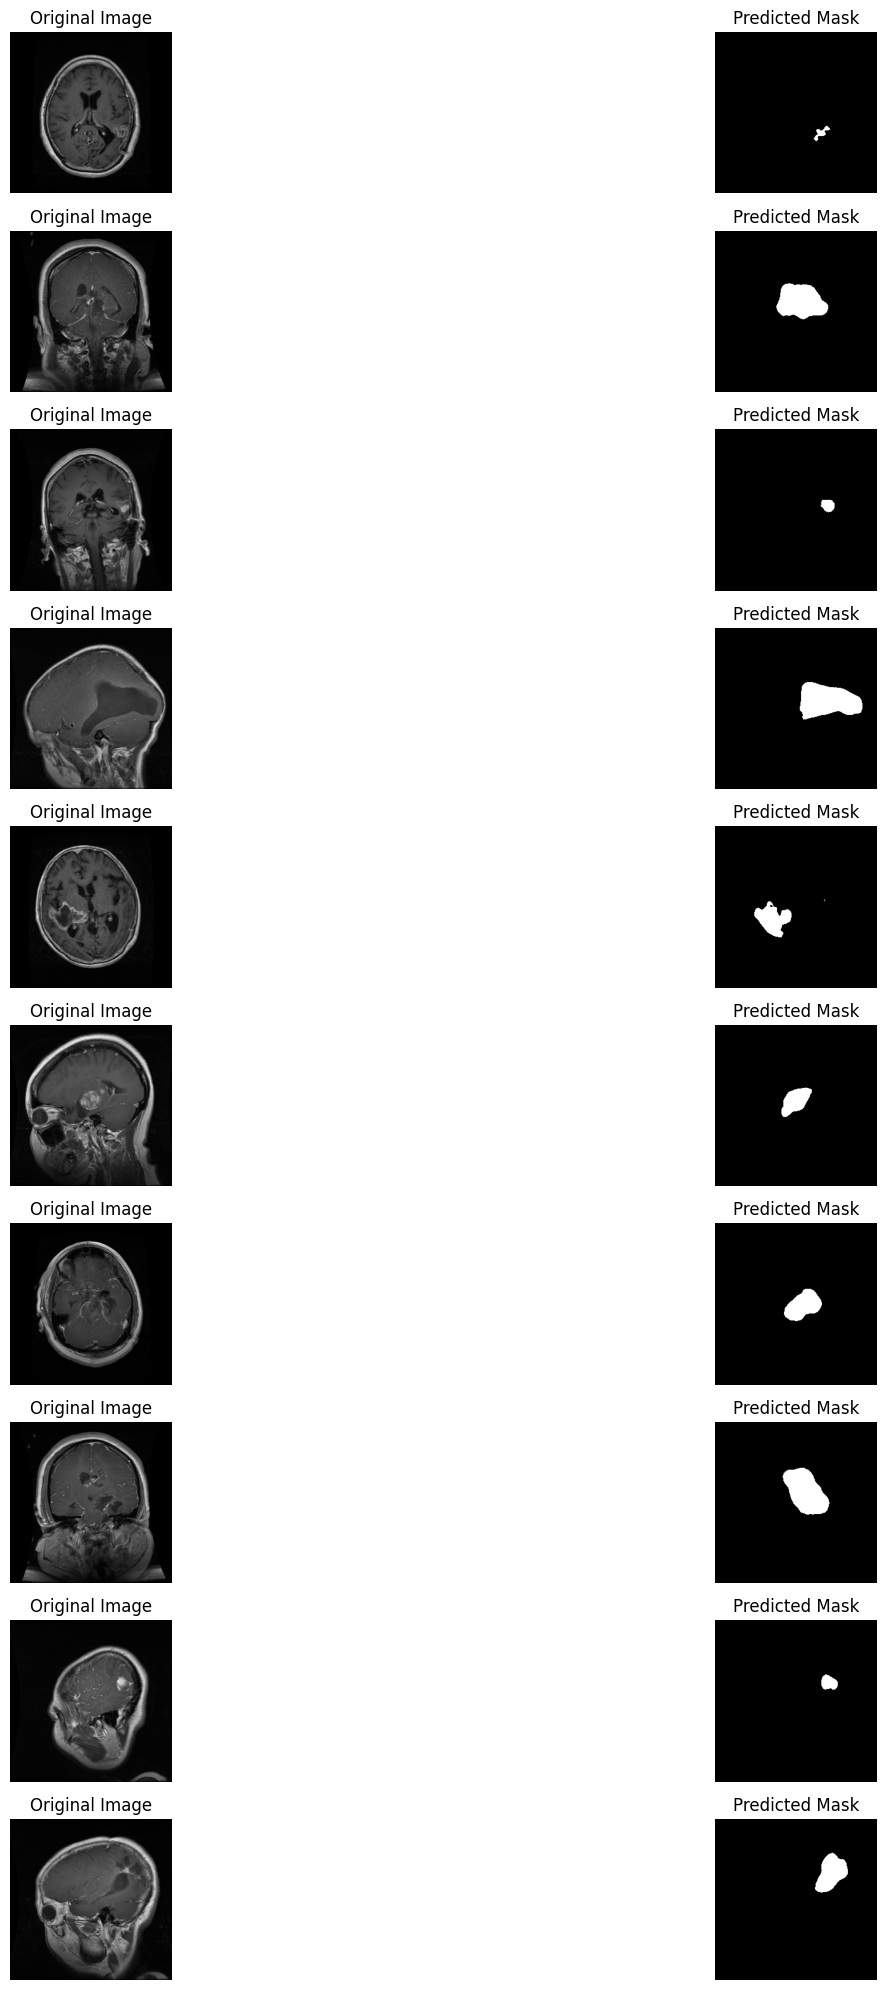

In [40]:
import os
import cv2
import matplotlib.pyplot as plt

# مسار المجلد الذي يحتوي على الصور الأصلية
g ='/content/resizedata/training_resized/glioma_tumor'

# عدد الصور التي تريد عرضها في كل مر
num_images = 10

# إنشاء شبكة لعرض الصور
plt.figure(figsize=(20, 20))

# حلقة عبر جميع الصور في المجلد
for i, filename in enumerate(os.listdir(g)):
    if i >= num_images:  # عرض عدد محدد من الصور
        break

    # مسار الصورة الأصلية
    image_path = os.path.join(g, filename)
    # مسار الماسك
    mask_path = os.path.join('/content/output/glioma_tumor', filename)

    # قراءة الصورة بالألوان
    A = cv2.imread(image_path, cv2.IMREAD_COLOR)
    A = cv2.cvtColor(A, cv2.COLOR_BGR2RGB)  # تحويل BGR إلى RGB

    # قراءة الماسك بالأبيض والأسود
    B = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # عرض الصورة الأصلية
    plt.subplot(num_images, 2, 2 * i + 1)  # (عدد الصور، عدد الأعمدة، موضع الصورة)
    plt.title("Original Image")
    plt.imshow(A)
    plt.axis('off')  # إخفاء المحاور

    # عرض الماسك
    plt.subplot(num_images, 2, 2 * i + 2)  # (عدد الصور، عدد الأعمدة، موضع الماسك)
    plt.title("Predicted Mask")
    plt.imshow(B, cmap='gray')  # عرض الماسك بالأبيض والأسود
    plt.axis('off')  # إخفاء المحاور

# عرض الصور
plt.tight_layout()
plt.show()


# **filter the masks**

In [27]:
import os
import cv2

# تحديد مسار مجلد الصور ومجلد الأقنعة
images_folder = '/content/resizedata/training_resized'  # قم بتعديل هذا المسار حسب الحاجة
masks_folder = '/content/output'  # قم بتعديل هذا المسار حسب الحاجة

# الحصول على قائمة بكل المجلدات الفرعية في مجلد الصور
subfolders = os.listdir(images_folder)

# حلقة على جميع المجلدات الفرعية
for subfolder in subfolders:
    # التحقق إذا كان المجلد هو "no tumor"
    if subfolder.lower() == "no_tumor":
        # تحديد مسار المجلد الفرعي للصور والقناع
        current_images_folder = os.path.join(images_folder, subfolder)
        current_masks_folder = os.path.join(masks_folder, subfolder)

        # الحصول على قائمة بكل الصور في المجلد الفرعي
        image_filenames = os.listdir(current_images_folder)

        # حلقة على جميع الصور
        for filename in image_filenames:
            # تحديد مسار الصورة ومسار القناع
            image_path = os.path.join(current_images_folder, filename)
            mask_path = os.path.join(current_masks_folder, filename)

            # قراءة القناع
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # حذف الصورة والقناع إذا كان القناع يحتوي على أي قيمة بيضاء (>= 1)
            if mask is not None and cv2.countNonZero(mask) > 0:
                print(f"Deleting {filename} in 'no_tumor' because its mask contains white values.")
                os.remove(image_path)
                os.remove(mask_path)  # حذف القناع أيضًا

    else:
        # إذا لم يكن المجلد هو "no_tumor"، يمكنك متابعة العملية المعتادة
        current_images_folder = os.path.join(images_folder, subfolder)
        current_masks_folder = os.path.join(masks_folder, subfolder)

        # الحصول على قائمة بكل الصور في المجلد الفرعي
        image_filenames = os.listdir(current_images_folder)

        # حلقة على جميع الصور
        for filename in image_filenames:
            # تحديد مسار الصورة ومسار القناع
            image_path = os.path.join(current_images_folder, filename)
            mask_path = os.path.join(current_masks_folder, filename)

            # قراءة القناع
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # التحقق إذا كان القناع أسود بالكامل (جميع القيم 0)
            if mask is not None and cv2.countNonZero(mask) == 0:
                # حذف الصورة إذا كان القناع أسود بالكامل
                print(f"Deleting {filename} in {subfolder} because its mask is black.")
                os.remove(image_path)
                os.remove(mask_path)  # حذف القناع أيضًا

print("Finished deleting images with masks containing white values in 'no tumor' and black masks in other folders.")


Deleting p (525).jpg in pituitary_tumor because its mask is black.
Deleting p (282).jpg in pituitary_tumor because its mask is black.
Deleting p (199).jpg in pituitary_tumor because its mask is black.
Deleting p (636).jpg in pituitary_tumor because its mask is black.
Deleting p (608).jpg in pituitary_tumor because its mask is black.
Deleting p (656).jpg in pituitary_tumor because its mask is black.
Deleting gg (531).jpg in glioma_tumor because its mask is black.
Deleting gg (163).jpg in glioma_tumor because its mask is black.
Deleting gg (88).jpg in glioma_tumor because its mask is black.
Deleting gg (809).jpg in glioma_tumor because its mask is black.
Deleting gg (573).jpg in glioma_tumor because its mask is black.
Deleting gg (500).jpg in glioma_tumor because its mask is black.
Deleting gg (614).jpg in glioma_tumor because its mask is black.
Deleting gg (721).jpg in glioma_tumor because its mask is black.
Deleting gg (483).jpg in glioma_tumor because its mask is black.
Deleting gg (5

# **save the product masks **

In [ ]:
import shutil
from google.colab import files

shutil.make_archive('/content/make','zip','/content/output')
files.download('/content/make.zip')